Lecture 2 (practice)
======================


## About

For this part of the assignment, you will gain hands-on experience working with Convolutional Neural Networks (CNNs).

* **Custom CNN Model**:

    Design and implement a custom CNN architecture tailored for the CIFAR-10, DTD, and COCO-O datasets. Train your model and evaluate its performance on each dataset. Consider discussing the design choices you made, such as the number of layers, types of layers, activation functions, etc., and how they contribute to your model's performance.

* **Linear Probe of ResNet**:

    Conduct a linear probe using the pre-trained ResNet features on the CIFAR-10, DTD, and COCO-O datasets. Analyze the effectiveness of transfer learning in speeding up training and improving accuracy. You may also want to compare this approach to training a model from scratch.

* **Fine-tuning ResNet model**:

    Fine-tune the ResNet model on the CIFAR-10, DTD, and COCO-O datasets to achieve better performance compared to the linear probe method. Discuss how fine-tuning impacts model accuracy and convergence speed. It's also worth exploring the balance between maintaining pre-trained knowledge and adapting to new tasks.


<hr>

* The <b><font color="red">red</font></b> color indicates the task that should be done, like <b><font color="red">[TODO]</font></b>: ...
* Addicitional comments, hints are in <b><font color="blue">blue</font></b>. For example <b><font color="blue">[HINT]</font></b>: ...

## Prelimiaries

In [1]:
!pip install datasets
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 159.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.7/308.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.1 MB/s eta 

In [1]:
import os
import gdown
import zipfile
from tqdm import tqdm
from copy import deepcopy

import datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

from datasets import load_dataset # HuggingFace dedicated lib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import fiftyone as fo

In [2]:
# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

## Auxilary functions

### Training related

In [3]:
def train_and_validate(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    num_epoch: int,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    max_iter: int | None = None,
    writer: SummaryWriter | None = None
) -> nn.Module:
    """Simple training script."""

    # Model to device
    model.to(device)

    # Log interval
    log_interval = max(1, int(len(train_loader) / 100))
    log_counter = 0

    best_val_accuracy = 0.0
    best_model_state = None
    for epoch in range(num_epoch):

        # Training part
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_amount = 0
        for batch_idx, (inputs, labels) in tqdm(enumerate(train_loader), 'training', total=len(train_loader)):

            # Move the inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            output = model(inputs)
            loss = criterion(output, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            _, preds = torch.max(output, 1)
            running_amount += inputs.size(0)
            running_loss += loss.item() * inputs.size(0)
            running_correct += torch.sum(preds == labels.data)

            # Log to tensorboard
            if writer and batch_idx % log_interval == 0:
                running_accuracy = (running_correct.float() / running_amount).item()
                writer.add_scalar('Train/Loss', running_loss / running_amount, log_counter)
                writer.add_scalar('Train/Accuracy', running_accuracy, log_counter)
                log_counter += 1

            if max_iter and batch_idx > max_iter:
                break

        # The train loss and accuracy
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_correct.float() / len(train_loader.dataset)

        # Evaluation part
        model.eval()
        running_loss = 0.0
        running_correct = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, 'evaluation', total=len(val_loader)):

                # Move the inputs and labels to the device
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_correct.float() / len(val_loader.dataset)

        # Best model
        if val_acc > best_val_accuracy:
            best_model_state = deepcopy(model.state_dict())
            best_val_accuracy = val_acc

        # Print the epoch results
        print(
            f'Epoch [{epoch + 1}/{num_epoch}], '
            f'train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, '
            f'val loss: {val_loss:.4f}, val acc: {val_acc:.4f}'
        )
        # Log to tensorboard
        if writer:
            writer.add_scalar('TrainEpoch/Loss', train_loss, epoch + 1)
            writer.add_scalar('TrainEpoch/Accuracy', train_acc, epoch + 1)
            writer.add_scalar('ValidationEpoch/Loss', val_loss, epoch + 1)
            writer.add_scalar('ValidationEpoch/Accuracy', val_acc, epoch + 1)

    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

In [4]:
def predict(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
) -> np.ndarray:
    """ Predict on a given dataloader. """
    model.to(device)
    model.eval()
    predictations = []
    ground_truth_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictations.extend(preds.cpu().numpy())
            ground_truth_labels.extend(labels)
    return np.array(predictations), np.array(ground_truth_labels)

### Models related

In [5]:
class SimpleNet(nn.Module):
    def __init__(self, n_classes: int):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Dataloader related

In [6]:
class DTDdataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.dataset)

In [7]:
transform_cifar = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [8]:
transform_imagenet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Load data

In [9]:
# Set the local folder with the data
path_data = "./data"
os.makedirs(path_data, exist_ok=True)

In [10]:
# Load cifar10 dataset
cifar10_dataset_train = torchvision.datasets.CIFAR10(root=path_data, train=True, download=True, transform=None)
cifar10_dataset_test = torchvision.datasets.CIFAR10(root=path_data, train=False, download=True, transform=None)
cifar10_classes_list = cifar10_dataset_train.classes

In [11]:
# Load DTD dataset
dtd_dataset = load_dataset("tanganke/dtd", cache_dir=path_data)
dtd_classes_list = dtd_dataset['train'].features['label'].names

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# Prepare COCO-O dataset
if not os.path.exists(os.path.join(path_data, 'ood_coco')):
    url = 'https://drive.google.com/uc?id=1aBfIJN0zo_i80Hv4p7Ch7M8pRzO37qbq'
    zip_file_path = os.path.join(path_data, 'ood_coco.zip')
    gdown.download(url, zip_file_path, quiet=False)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(path_data)
cocoo_classes_list = os.listdir(os.path.join(path_data, 'ood_coco'))

## Training (from scratch)

In [13]:
# Set the device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [14]:
# We will use 'crossentropy' for all classification problems
criterion = nn.CrossEntropyLoss()

### cifar10

In [15]:
# settings
num_epoch = 3
learning_rate = 0.01
momentum = 0.9
batch_size = 32

In [16]:
# Prepare dataloaders
trainset = torchvision.datasets.CIFAR10(root=path_data, train=True, transform=transform_cifar)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root=path_data, train=False, transform=transform_cifar)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [17]:
# Let's have a look at the sizes of the loaders
print(len(trainloader))
print(len(testloader))

# Let's check sizes of the batch and their types
images, labels = next(iter(testloader))
print(images.shape, type(images))
print(labels.shape, type(labels))

1563
313
torch.Size([32, 3, 32, 32]) <class 'torch.Tensor'>
torch.Size([32]) <class 'torch.Tensor'>


In [18]:
# Set-up model and optimizer
model_cifar = SimpleNet(n_classes=10)
optimizer = torch.optim.SGD(model_cifar.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
# Let's train!

In [19]:
%%time
best_model = train_and_validate(
    model=model_cifar,
    train_loader=trainloader,
    val_loader=testloader,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

evaluation: 100%|██████████| 313/313 [00:02<00:00, 112.06it/s]


Epoch [1/3], train loss: 1.6475, train acc: 0.3983, val loss: 1.3955, val acc: 0.4998


evaluation: 100%|██████████| 313/313 [00:03<00:00, 101.09it/s]


Epoch [2/3], train loss: 1.3343, train acc: 0.5271, val loss: 1.3083, val acc: 0.5409


evaluation: 100%|██████████| 313/313 [00:02<00:00, 112.22it/s]

Epoch [3/3], train loss: 1.2188, train acc: 0.5732, val loss: 1.2416, val acc: 0.5683
CPU times: user 60 s, sys: 570 ms, total: 1min
Wall time: 1min 1s


In [20]:
# Make predictations
predictations, true_labels = predict(model=best_model, data_loader=testloader, device=device)

In [21]:
# Detailed analysis (report)
print(classification_report(true_labels, predictations, target_names=cifar10_classes_list))

              precision    recall  f1-score   support

    airplane       0.71      0.59      0.65      1000
  automobile       0.73      0.69      0.71      1000
        bird       0.56      0.30      0.39      1000
         cat       0.37      0.41      0.39      1000
        deer       0.39      0.70      0.50      1000
         dog       0.51      0.43      0.47      1000
        frog       0.67      0.61      0.64      1000
       horse       0.66      0.65      0.66      1000
        ship       0.79      0.54      0.65      1000
       truck       0.55      0.76      0.64      1000

    accuracy                           0.57     10000
   macro avg       0.59      0.57      0.57     10000
weighted avg       0.59      0.57      0.57     10000



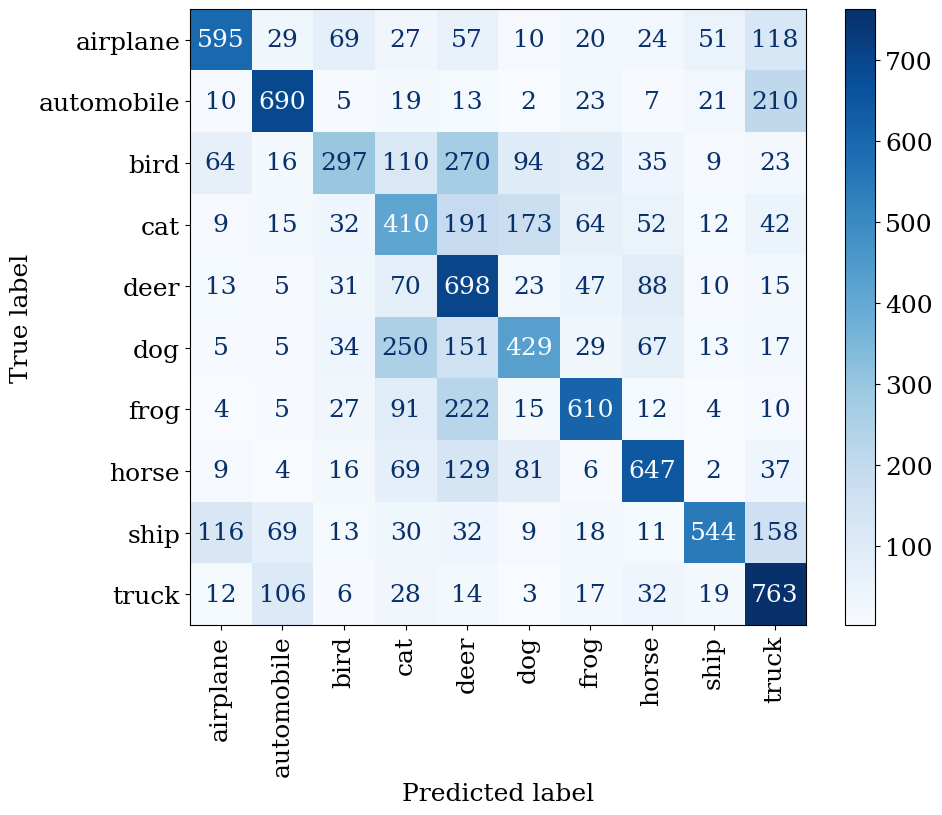

In [22]:
# Detailed analysis (confusion matrix)

cm = confusion_matrix(true_labels, predictations)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_classes_list)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90);

### DTD

In [24]:
# settings
num_epoch = 5
learning_rate = 0.01
momentum = 0.9
batch_size = 32

In [25]:
# Prepare dataloaders
trainset = DTDdataset(dtd_dataset['train'], transform=transform_cifar)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = DTDdataset(dtd_dataset['test'], transform=transform_cifar)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

<b><font color="red">[TODO]</font></b>: Following the example of 'cifar10' dataset complete the training from scratch for DTD dataset from this point.

What is the accuracy? Why?

**Note**: you can do this part either for DTD or for COCO-D dataset. But you can do both, if you like!


In [23]:
# YOUR CODE HERE
model_dtd = SimpleNet(n_classes=47)
optimizer_dtd = torch.optim.SGD(model_dtd.parameters(), lr=learning_rate, momentum=momentum)

In [26]:
%%time
best_model_dtd = train_and_validate(
    model=model_dtd,
    train_loader=trainloader,
    val_loader=testloader,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer_dtd,
    device=device
)

evaluation: 100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch [1/5], train loss: 3.8502, train acc: 0.0324, val loss: 3.8366, val acc: 0.0394


evaluation: 100%|██████████| 59/59 [00:06<00:00,  9.61it/s]


Epoch [2/5], train loss: 3.8039, train acc: 0.0463, val loss: 3.7642, val acc: 0.0479


evaluation: 100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch [3/5], train loss: 3.7496, train acc: 0.0500, val loss: 3.7182, val acc: 0.0676


evaluation: 100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch [4/5], train loss: 3.7013, train acc: 0.0612, val loss: 3.6820, val acc: 0.0644


evaluation: 100%|██████████| 59/59 [00:08<00:00,  6.87it/s]

Epoch [5/5], train loss: 3.6601, train acc: 0.0795, val loss: 3.6537, val acc: 0.0798
CPU times: user 1min 46s, sys: 421 ms, total: 1min 46s
Wall time: 1min 51s


In [27]:
predictions_dtd, true_labels_dtd = predict(model=best_model_dtd, data_loader=testloader, device=device)

In [28]:
# accuracy is terrible because we are using transform_cifar in dataloaders for DTD and also this is what SimpleNet was designed for. For this dataset we should use different model and different size
print(classification_report(true_labels_dtd, predictions_dtd, target_names=dtd_classes_list))

              precision    recall  f1-score   support

      banded       0.00      0.00      0.00        40
     blotchy       0.00      0.00      0.00        40
     braided       0.00      0.00      0.00        40
      bubbly       0.05      0.03      0.03        40
       bumpy       0.00      0.00      0.00        40
   chequered       0.08      0.62      0.14        40
   cobwebbed       0.00      0.00      0.00        40
     cracked       0.00      0.00      0.00        40
crosshatched       0.00      0.00      0.00        40
 crystalline       0.00      0.00      0.00        40
      dotted       0.05      0.05      0.05        40
     fibrous       0.00      0.00      0.00        40
     flecked       0.12      0.57      0.20        40
    freckled       0.04      0.15      0.07        40
      frilly       0.00      0.00      0.00        40
       gauzy       0.00      0.00      0.00        40
        grid       0.00      0.00      0.00        40
     grooved       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### COCO-O

In [ ]:
# settings
num_epoch = 5
learning_rate = 0.01
momentum = 0.9
batch_size = 32

<b><font color="red">[TODO]</font></b>: Following the example of 'cifar10' dataset complete the training from scratch for COCO-O dataset from this point.

<b><font color="blue">[HINT]</font></b>: You will need to write the custom class for the dataloader similar to 'DTDdataset'.

What is the accuracy? Why?

**Note**: you can do this part either for DTD or for COCO-D dataset. But you can do both, if you like!

In [ ]:
# YOUR CODE HERE

## Training (Fine-tuning)

In [45]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

### cifar10

In [46]:
# Settings
num_epoch = 3
learning_rate = 0.01
momentum = 0.9
batch_size = 32

In [47]:
# Prepare dataloaders
# Note that we've changed the 'transform'
trainset = torchvision.datasets.CIFAR10(root=path_data, train=True, transform=transform_imagenet)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root=path_data, train=False, transform=transform_imagenet)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [48]:
# Prepare model
model_cifar = resnet18(weights=ResNet18_Weights.DEFAULT)

In [49]:
# STEP 1: We will first train only the last layer, freezing the rest of parameters.
# This can be considered as a getting 'resnet' features and making linear probe on top of this.
for param in model_cifar.parameters():
    param.requires_grad = False

In [50]:
# Modify the very last layer
num_classes = len(cifar10_classes_list)
model_cifar.fc = torch.nn.Linear(model_cifar.fc.in_features, num_classes)

In [51]:
# Set-up optimizer
optimizer = torch.optim.SGD(model_cifar.parameters(), lr=learning_rate, momentum=momentum)

In [52]:
# We repeat the same training process as before.
# Note: To expedite the process, the parameter max_iter is set to 100. Consider increasing this value if you want to achieve better results.
best_model = train_and_validate(
    model=model_cifar,
    train_loader=trainloader,
    val_loader=testloader,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    max_iter=100
)

evaluation: 100%|██████████| 313/313 [00:25<00:00, 12.36it/s]


Epoch [1/3], train loss: 0.0859, train acc: 0.0358, val loss: 1.0465, val acc: 0.6655


evaluation: 100%|██████████| 313/313 [00:25<00:00, 12.40it/s]


Epoch [2/3], train loss: 0.0636, train acc: 0.0433, val loss: 0.8353, val acc: 0.7200


evaluation: 100%|██████████| 313/313 [00:25<00:00, 12.36it/s]

Epoch [3/3], train loss: 0.0655, train acc: 0.0443, val loss: 1.1038, val acc: 0.6660


In [53]:
# As the same type of analysis of predictations
predictations, true_labels = predict(model=best_model, data_loader=testloader, device=device)
print(classification_report(true_labels, predictations, target_names=cifar10_classes_list))

              precision    recall  f1-score   support

    airplane       0.68      0.81      0.74      1000
  automobile       0.95      0.63      0.76      1000
        bird       0.86      0.43      0.58      1000
         cat       0.64      0.57      0.60      1000
        deer       0.60      0.79      0.68      1000
         dog       0.64      0.78      0.70      1000
        frog       0.67      0.84      0.75      1000
       horse       0.84      0.68      0.75      1000
        ship       0.77      0.81      0.79      1000
       truck       0.78      0.86      0.82      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000



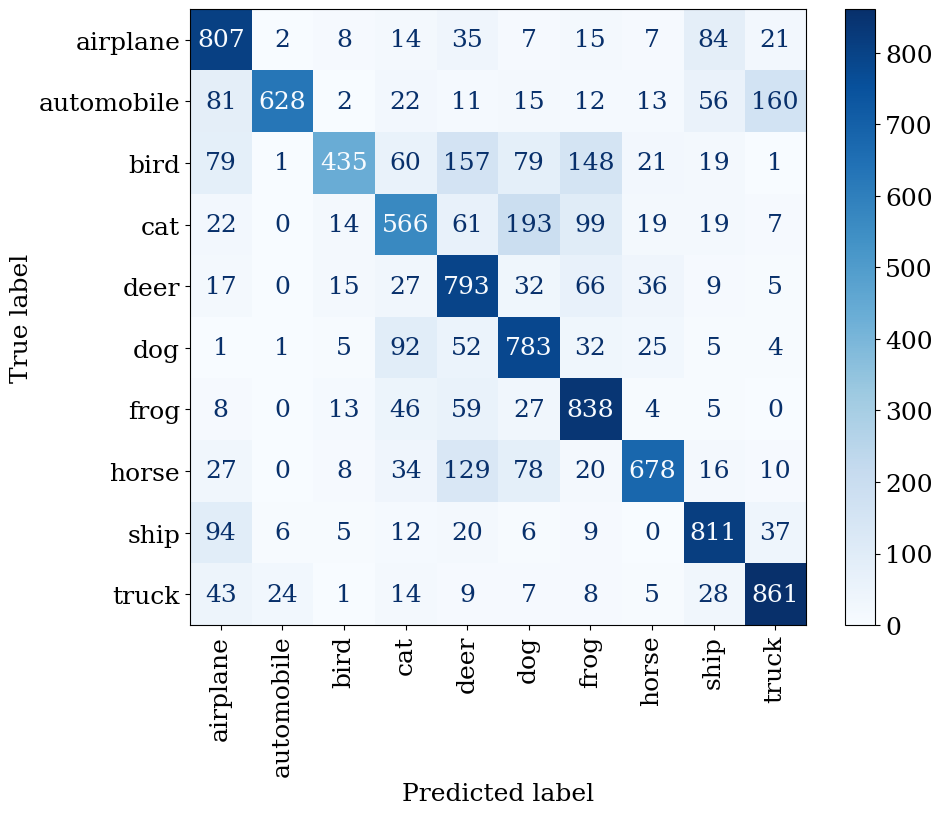

In [54]:
# Detailed analysis (confusion matrix)

cm = confusion_matrix(true_labels, predictations)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_classes_list)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90);

<b><font color="red">[TODO]</font></b>: Instead of resnet18, use convnext_tiny.

<b><font color="blue">[HINT]</font></b>: Check the documentation https://docs.pytorch.org/vision/main/models/generated/torchvision.models.convnext_tiny.html#torchvision.models.convnext_tiny.

What is the difference between resnet18 and convnext_tiny accuracy?

In [55]:
# convnext_tiny
trainset = torchvision.datasets.CIFAR10(root=path_data, train=True, transform=transform_imagenet)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root=path_data, train=False, transform=transform_imagenet)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

model_cifar = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)

for param in model_cifar.parameters():
    param.requires_grad = False

# For ConvNeXt, the classifier is in model.classifier[2] instead of model.fc
num_classes = len(cifar10_classes_list)
model_cifar.classifier[2] = torch.nn.Linear(model_cifar.classifier[2].in_features, num_classes)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 209MB/s]


In [56]:
optimizer = torch.optim.SGD(model_cifar.parameters(), lr=learning_rate, momentum=momentum)

best_model = train_and_validate(
    model=model_cifar,
    train_loader=trainloader,
    val_loader=testloader,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    max_iter=100
)

evaluation: 100%|██████████| 313/313 [00:55<00:00,  5.64it/s]


Epoch [1/3], train loss: 0.0418, train acc: 0.0513, val loss: 0.3214, val acc: 0.8924


evaluation: 100%|██████████| 313/313 [00:54<00:00,  5.73it/s]


Epoch [2/3], train loss: 0.0205, train acc: 0.0581, val loss: 0.2946, val acc: 0.9015


evaluation: 100%|██████████| 313/313 [00:54<00:00,  5.74it/s]

Epoch [3/3], train loss: 0.0195, train acc: 0.0588, val loss: 0.2734, val acc: 0.9068


In [57]:
predictations, true_labels = predict(model=best_model, data_loader=testloader, device=device)
print(classification_report(true_labels, predictations, target_names=cifar10_classes_list))

              precision    recall  f1-score   support

    airplane       0.92      0.92      0.92      1000
  automobile       0.94      0.96      0.95      1000
        bird       0.95      0.82      0.88      1000
         cat       0.86      0.81      0.83      1000
        deer       0.86      0.93      0.89      1000
         dog       0.82      0.92      0.86      1000
        frog       0.91      0.95      0.93      1000
       horse       0.96      0.89      0.92      1000
        ship       0.94      0.95      0.95      1000
       truck       0.94      0.93      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [58]:
# STEP 2: Relax 'freezing' contstrains and let's train the whole network
for param in model_cifar.parameters():
    param.requires_grad = True

# Also decrease the learning rate. Why we are doing this?
# This is normal learning rate for the full fine tuning, because mose layers are well optimized. We only increase it for the last frozen probe because it needs to learn from scratch
learning_rate = 0.001
optimizer = torch.optim.SGD(model_cifar.parameters(), lr=learning_rate, momentum=momentum)

In [59]:
# Finally do the same training we did before
best_model = train_and_validate(
    model=model_cifar,
    train_loader=trainloader,
    val_loader=testloader,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    max_iter=100
)

evaluation: 100%|██████████| 313/313 [00:53<00:00,  5.88it/s]


Epoch [1/3], train loss: 0.0387, train acc: 0.0527, val loss: 0.3521, val acc: 0.8843


evaluation: 100%|██████████| 313/313 [00:53<00:00,  5.81it/s]


Epoch [2/3], train loss: 0.0220, train acc: 0.0578, val loss: 0.2499, val acc: 0.9155


evaluation: 100%|██████████| 313/313 [00:53<00:00,  5.85it/s]

Epoch [3/3], train loss: 0.0200, train acc: 0.0586, val loss: 0.2239, val acc: 0.9239


In [60]:
# As the same type of analysis of predictations
predictations, true_labels = predict(model=best_model, data_loader=testloader, device=device)
print(classification_report(true_labels, predictations, target_names=cifar10_classes_list))

              precision    recall  f1-score   support

    airplane       0.92      0.94      0.93      1000
  automobile       0.94      0.98      0.96      1000
        bird       0.86      0.95      0.90      1000
         cat       0.83      0.90      0.87      1000
        deer       0.97      0.83      0.90      1000
         dog       0.95      0.83      0.88      1000
        frog       0.93      0.97      0.95      1000
       horse       0.92      0.95      0.94      1000
        ship       0.98      0.93      0.95      1000
       truck       0.96      0.95      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



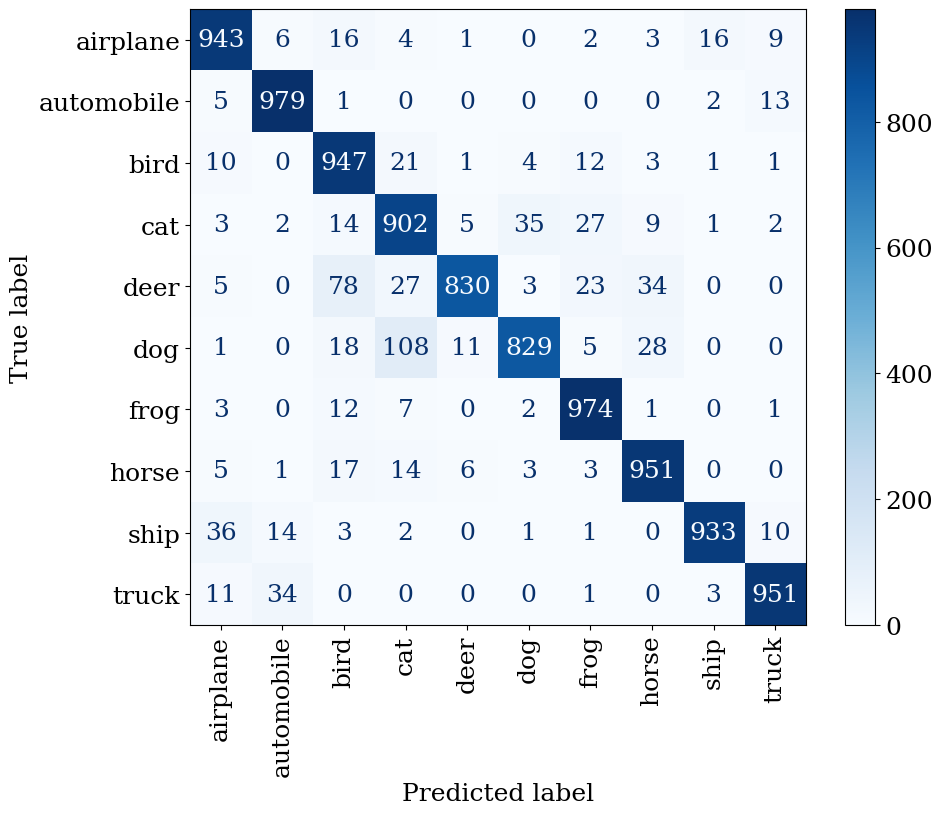

In [61]:
# Detailed analysis (confusion matrix)

cm = confusion_matrix(true_labels, predictations)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_classes_list)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90);

### DTD

<b><font color="red">[TODO]</font></b>: Conduct fine-tuning experiments for DTD dataset. What is the accuracy, how does it compare to the 'from-scratch' experiments?

**Note**: you can do this part either for DTD or for COCO-D dataset. But you can do both, if you like!

In [62]:
# settings
num_epoch = 5
learning_rate = 0.01
momentum = 0.9
batch_size = 32

trainset = DTDdataset(dtd_dataset['train'], transform=transform_imagenet)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = DTDdataset(dtd_dataset['test'], transform=transform_imagenet)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Prepare model - using ConvNeXt Tiny
model_dtd = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)

# STEP 1: Freeze all parameters (linear probe)
for param in model_dtd.parameters():
    param.requires_grad = False

In [63]:
num_classes = len(dtd_classes_list)
model_dtd.classifier[2] = torch.nn.Linear(model_dtd.classifier[2].in_features, num_classes)

In [64]:
optimizer = torch.optim.SGD(model_dtd.parameters(), lr=learning_rate, momentum=momentum)

best_model_dtd = train_and_validate(
    model=model_dtd,
    train_loader=trainloader,
    val_loader=testloader,
    num_epoch=num_epoch,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    max_iter=100
)

evaluation: 100%|██████████| 59/59 [00:19<00:00,  3.09it/s]


Epoch [1/5], train loss: 1.8434, train acc: 0.4516, val loss: 1.2317, val acc: 0.6936


evaluation: 100%|██████████| 59/59 [00:16<00:00,  3.48it/s]


Epoch [2/5], train loss: 0.8427, train acc: 0.6497, val loss: 1.0333, val acc: 0.7293


evaluation: 100%|██████████| 59/59 [00:16<00:00,  3.48it/s]


Epoch [3/5], train loss: 0.6519, train acc: 0.6960, val loss: 0.9581, val acc: 0.7431


evaluation: 100%|██████████| 59/59 [00:17<00:00,  3.46it/s]


Epoch [4/5], train loss: 0.5421, train acc: 0.7306, val loss: 0.9259, val acc: 0.7431


evaluation: 100%|██████████| 59/59 [00:17<00:00,  3.46it/s]


Epoch [5/5], train loss: 0.4774, train acc: 0.7455, val loss: 0.9040, val acc: 0.7495


In [65]:
predictions_dtd, true_labels_dtd = predict(model=best_model_dtd, data_loader=testloader, device=device)
print(classification_report(true_labels_dtd, predictions_dtd, target_names=dtd_classes_list))

              precision    recall  f1-score   support

      banded       0.78      0.80      0.79        40
     blotchy       0.48      0.53      0.50        40
     braided       0.60      0.68      0.64        40
      bubbly       0.86      0.90      0.88        40
       bumpy       0.67      0.50      0.57        40
   chequered       0.86      0.95      0.90        40
   cobwebbed       0.88      0.93      0.90        40
     cracked       0.75      0.75      0.75        40
crosshatched       0.74      0.65      0.69        40
 crystalline       0.84      0.95      0.89        40
      dotted       0.73      0.47      0.58        40
     fibrous       0.84      0.68      0.75        40
     flecked       0.70      0.75      0.72        40
    freckled       0.94      0.82      0.88        40
      frilly       0.86      0.80      0.83        40
       gauzy       0.74      0.88      0.80        40
        grid       0.65      0.55      0.59        40
     grooved       0.76    

In [66]:
# unfreeze
for param in best_model_dtd.parameters():
    param.requires_grad = True

learning_rate_finetune = 0.001
optimizer_finetune = torch.optim.SGD(best_model_dtd.parameters(), lr=learning_rate_finetune, momentum=momentum)

num_epoch_finetune = 3
best_model_dtd_finetuned = train_and_validate(
    model=best_model_dtd,
    train_loader=trainloader,
    val_loader=testloader,
    num_epoch=num_epoch_finetune,
    criterion=criterion,
    optimizer=optimizer_finetune,
    device=device
)

evaluation: 100%|██████████| 59/59 [00:16<00:00,  3.51it/s]


Epoch [1/3], train loss: 0.8645, train acc: 0.7431, val loss: 1.1746, val acc: 0.6612


evaluation: 100%|██████████| 59/59 [00:17<00:00,  3.46it/s]


Epoch [2/3], train loss: 0.5807, train acc: 0.8133, val loss: 0.9321, val acc: 0.7330


evaluation: 100%|██████████| 59/59 [00:17<00:00,  3.41it/s]


Epoch [3/3], train loss: 0.4259, train acc: 0.8710, val loss: 0.9825, val acc: 0.7181


In [67]:
predictions_dtd_final, true_labels_dtd_final = predict(model=best_model_dtd_finetuned, data_loader=testloader, device=device)
print(classification_report(true_labels_dtd_final, predictions_dtd_final, target_names=dtd_classes_list))

              precision    recall  f1-score   support

      banded       0.75      0.82      0.79        40
     blotchy       0.53      0.45      0.49        40
     braided       0.71      0.68      0.69        40
      bubbly       0.88      0.88      0.88        40
       bumpy       0.67      0.45      0.54        40
   chequered       0.86      0.93      0.89        40
   cobwebbed       0.88      0.90      0.89        40
     cracked       0.52      0.80      0.63        40
crosshatched       0.62      0.60      0.61        40
 crystalline       0.79      0.93      0.85        40
      dotted       0.68      0.68      0.68        40
     fibrous       0.80      0.60      0.69        40
     flecked       0.76      0.62      0.68        40
    freckled       0.95      0.88      0.91        40
      frilly       0.94      0.78      0.85        40
       gauzy       0.61      0.75      0.67        40
        grid       0.55      0.70      0.62        40
     grooved       0.74    

### COCO-O

<b><font color="red">[TODO]</font></b>: Conduct fine-tuning experiments for COCO-O dataset. What is the accuracy, how does it compare to the 'from-scratch' experiments?

**Note**: you can do this part either for DTD or for COCO-D dataset. But you can do both, if you like!

## Analysis of the results with FiftyOne lib

<b><font color="red">[TODO]</font></b>: Using the example from the previous 'tutorial01_data.ipynb' session and the guidance from the provided [LINK](https://docs.voxel51.com/recipes/adding_classifications.html), analyze the COCO-O results using the FiftyOne tool. Specifically, focus on examining instances where the predictions do not align with the ground truth labels.